# Discrete A/B Test

Prior Distribution:
- A Beta prior with parameters \(\alpha_{\text{prior}} = 1\) and \(\beta_{\text{prior}} = 1\), representing a uniform distribution (non-informative prior).

Posterior Distribution:
- Posterior parameters for the Beta distribution are calculated as follows:

$$
\alpha_{\text{post}} = \alpha_{\text{prior}} + \text{successes}
$$

$$
\beta_{\text{post}} = \beta_{\text{prior}} + (\text{trials} - \text{successes})
$$

Bayes Factor:
- The Bayes Factor is calculated to quantify the evidence in favor of the control group having a better conversion rate than the treatment group:

$$
\text{BF} = \frac{P(\text{control\_samples} > \text{treatment\_samples})}{P(\text{control\_samples} \leq \text{treatment\_samples})}
$$

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Experiment outcomes (PLAY WITH THIS)
control_successes = 60
control_trials = 138

treatment_A_successes = 87
treatment_A_trials = 154

treatment_B_successes = 132
treatment_B_trials = 152
target_variable = 'F7D file uploaded'

# Variant labels
variants = ['Default', 'Magic onboarding', 'Product tour']

# Define prior parameters for Beta distribution
alpha_prior = 1
beta_prior = 1

/var/folders/65/1b1td3_n3f977_x9vc2b967w0000gn/T/ipykernel_48509/754803685.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  return p_samples1_better / p_samples2_better


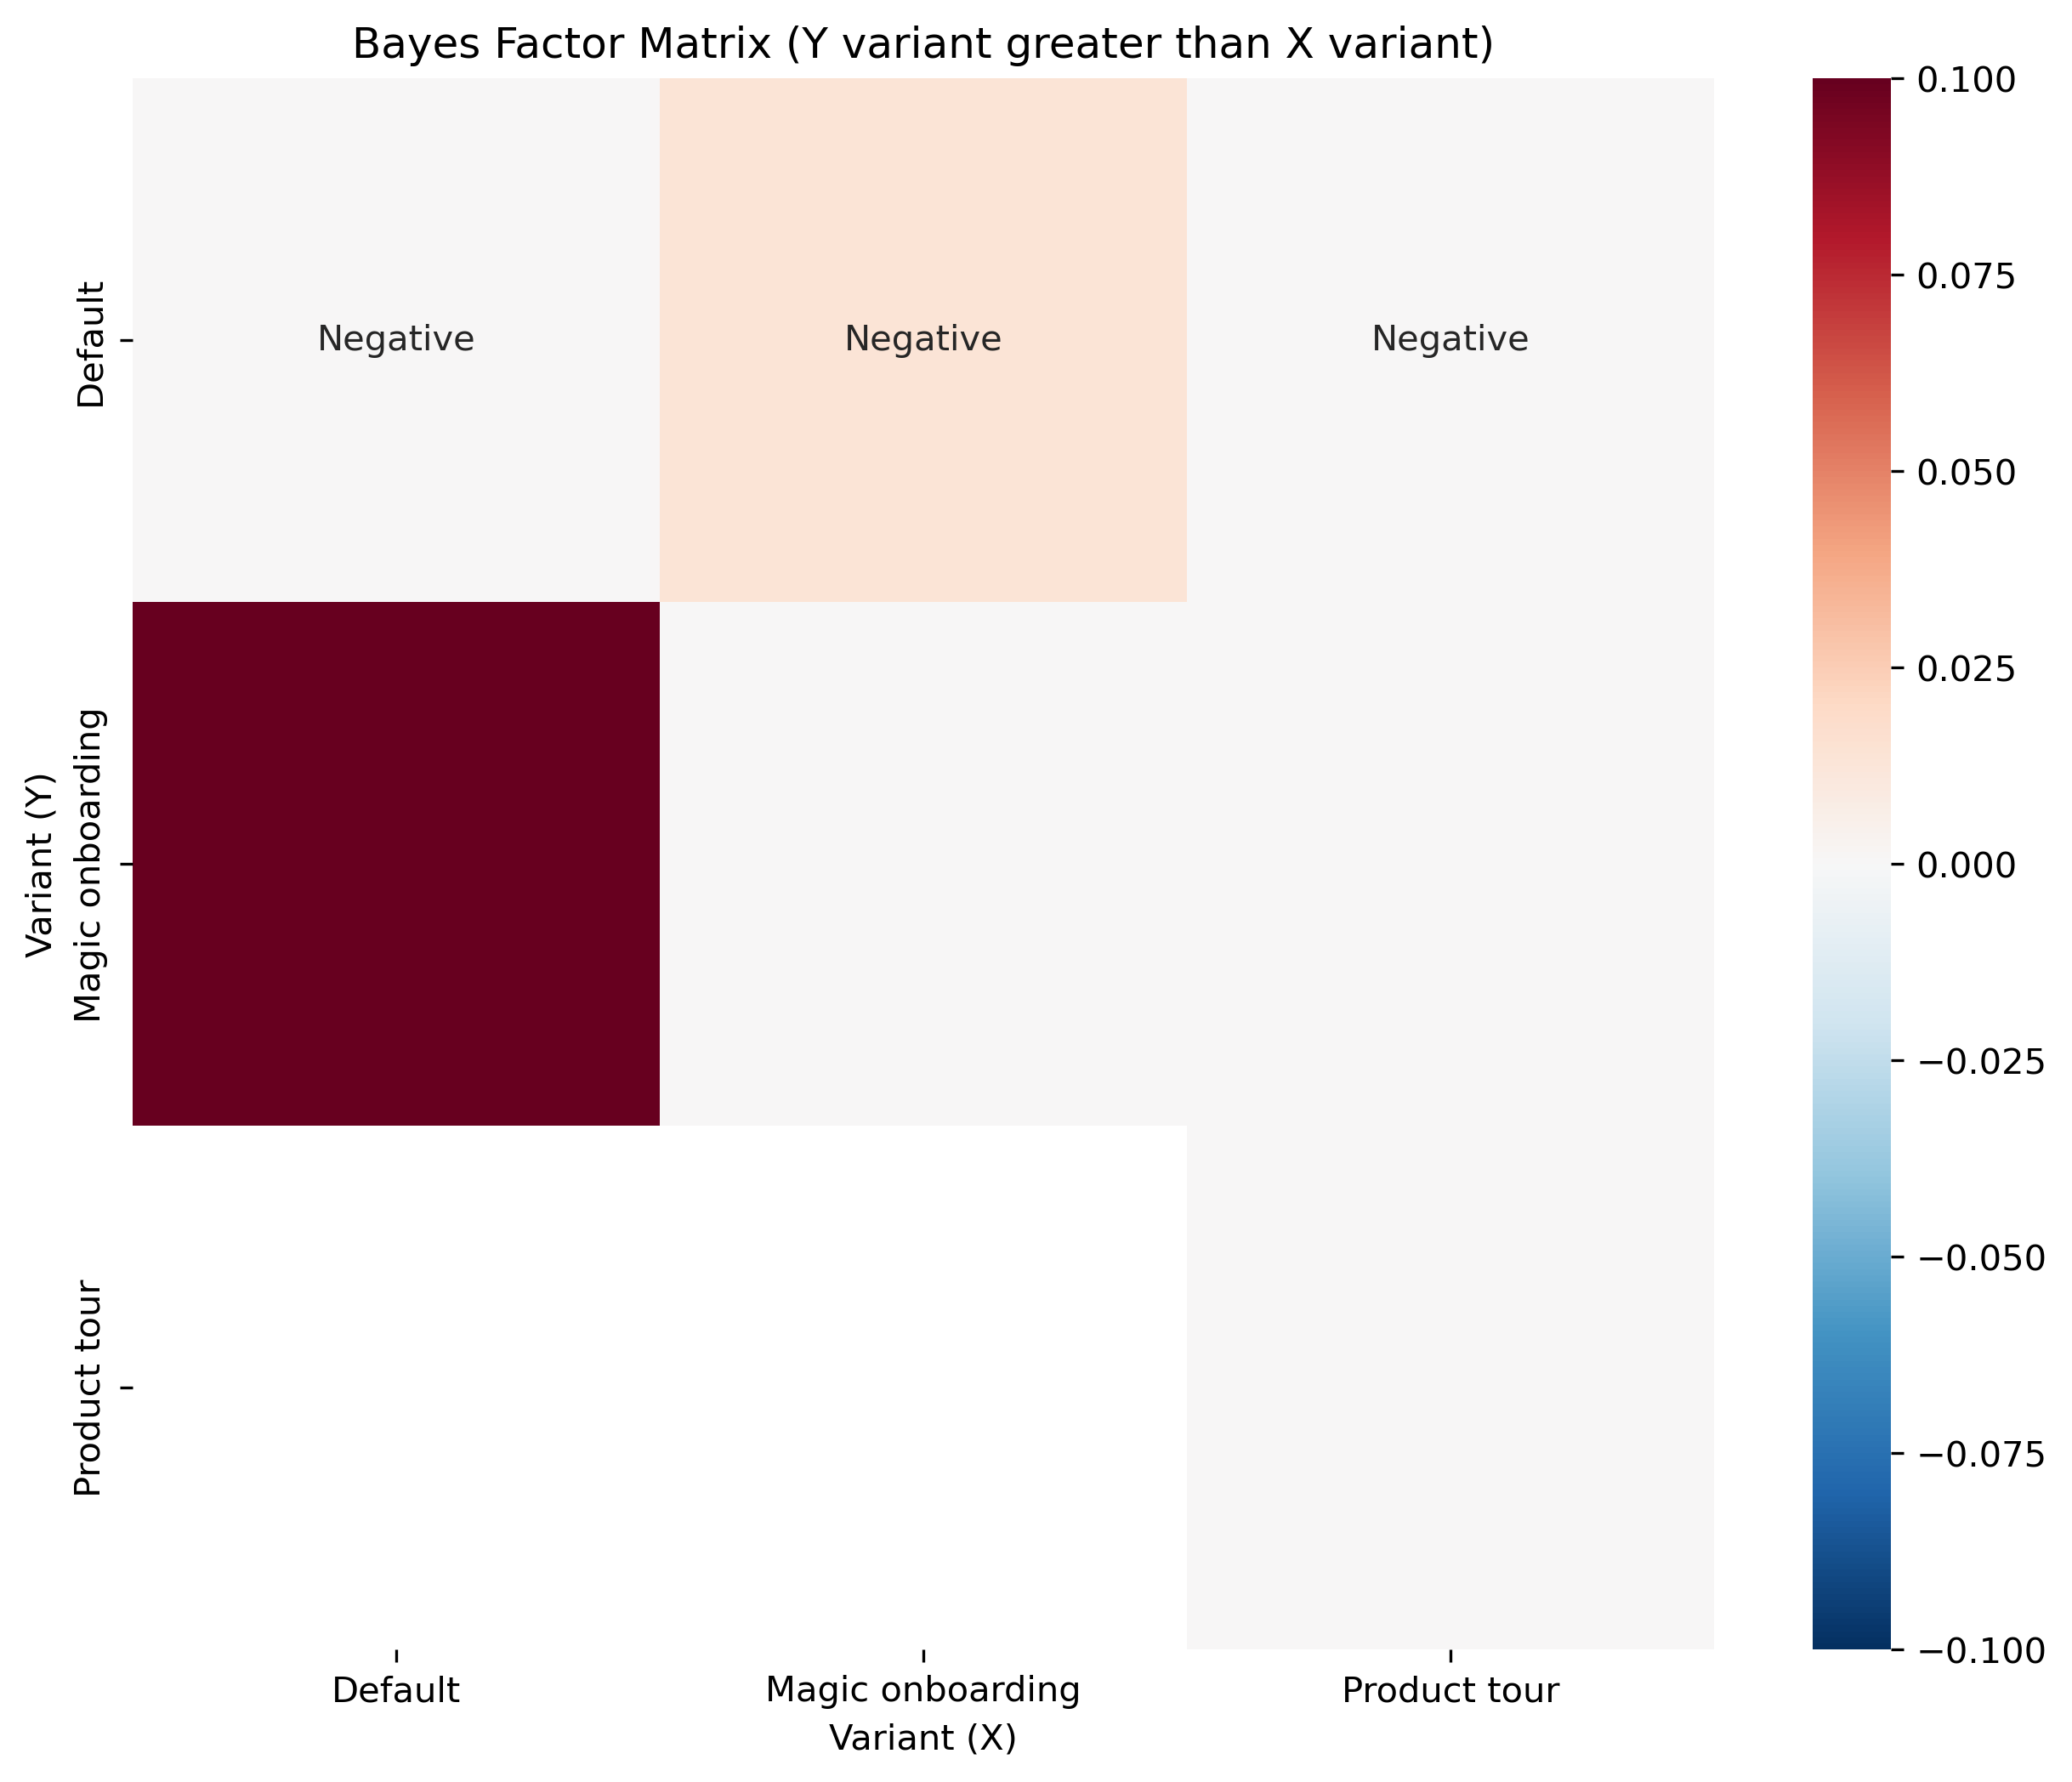

95% Credible Intervals for Rates:
Default Group: [35.48%, 51.82%]
Magic onboarding Group: [48.58%, 64.07%]
Product tour Group: [80.53%, 91.30%]

Mean Conversion Rates:
Default Group: 43.57%
Magic onboarding Group: 56.41%
Product tour Group: 86.36%

The credible intervals overlap, indicating no significant difference between the groups.
Percentage Uplift for Magic onboarding: 29.47%
Percentage Uplift for Product tour: 98.23%


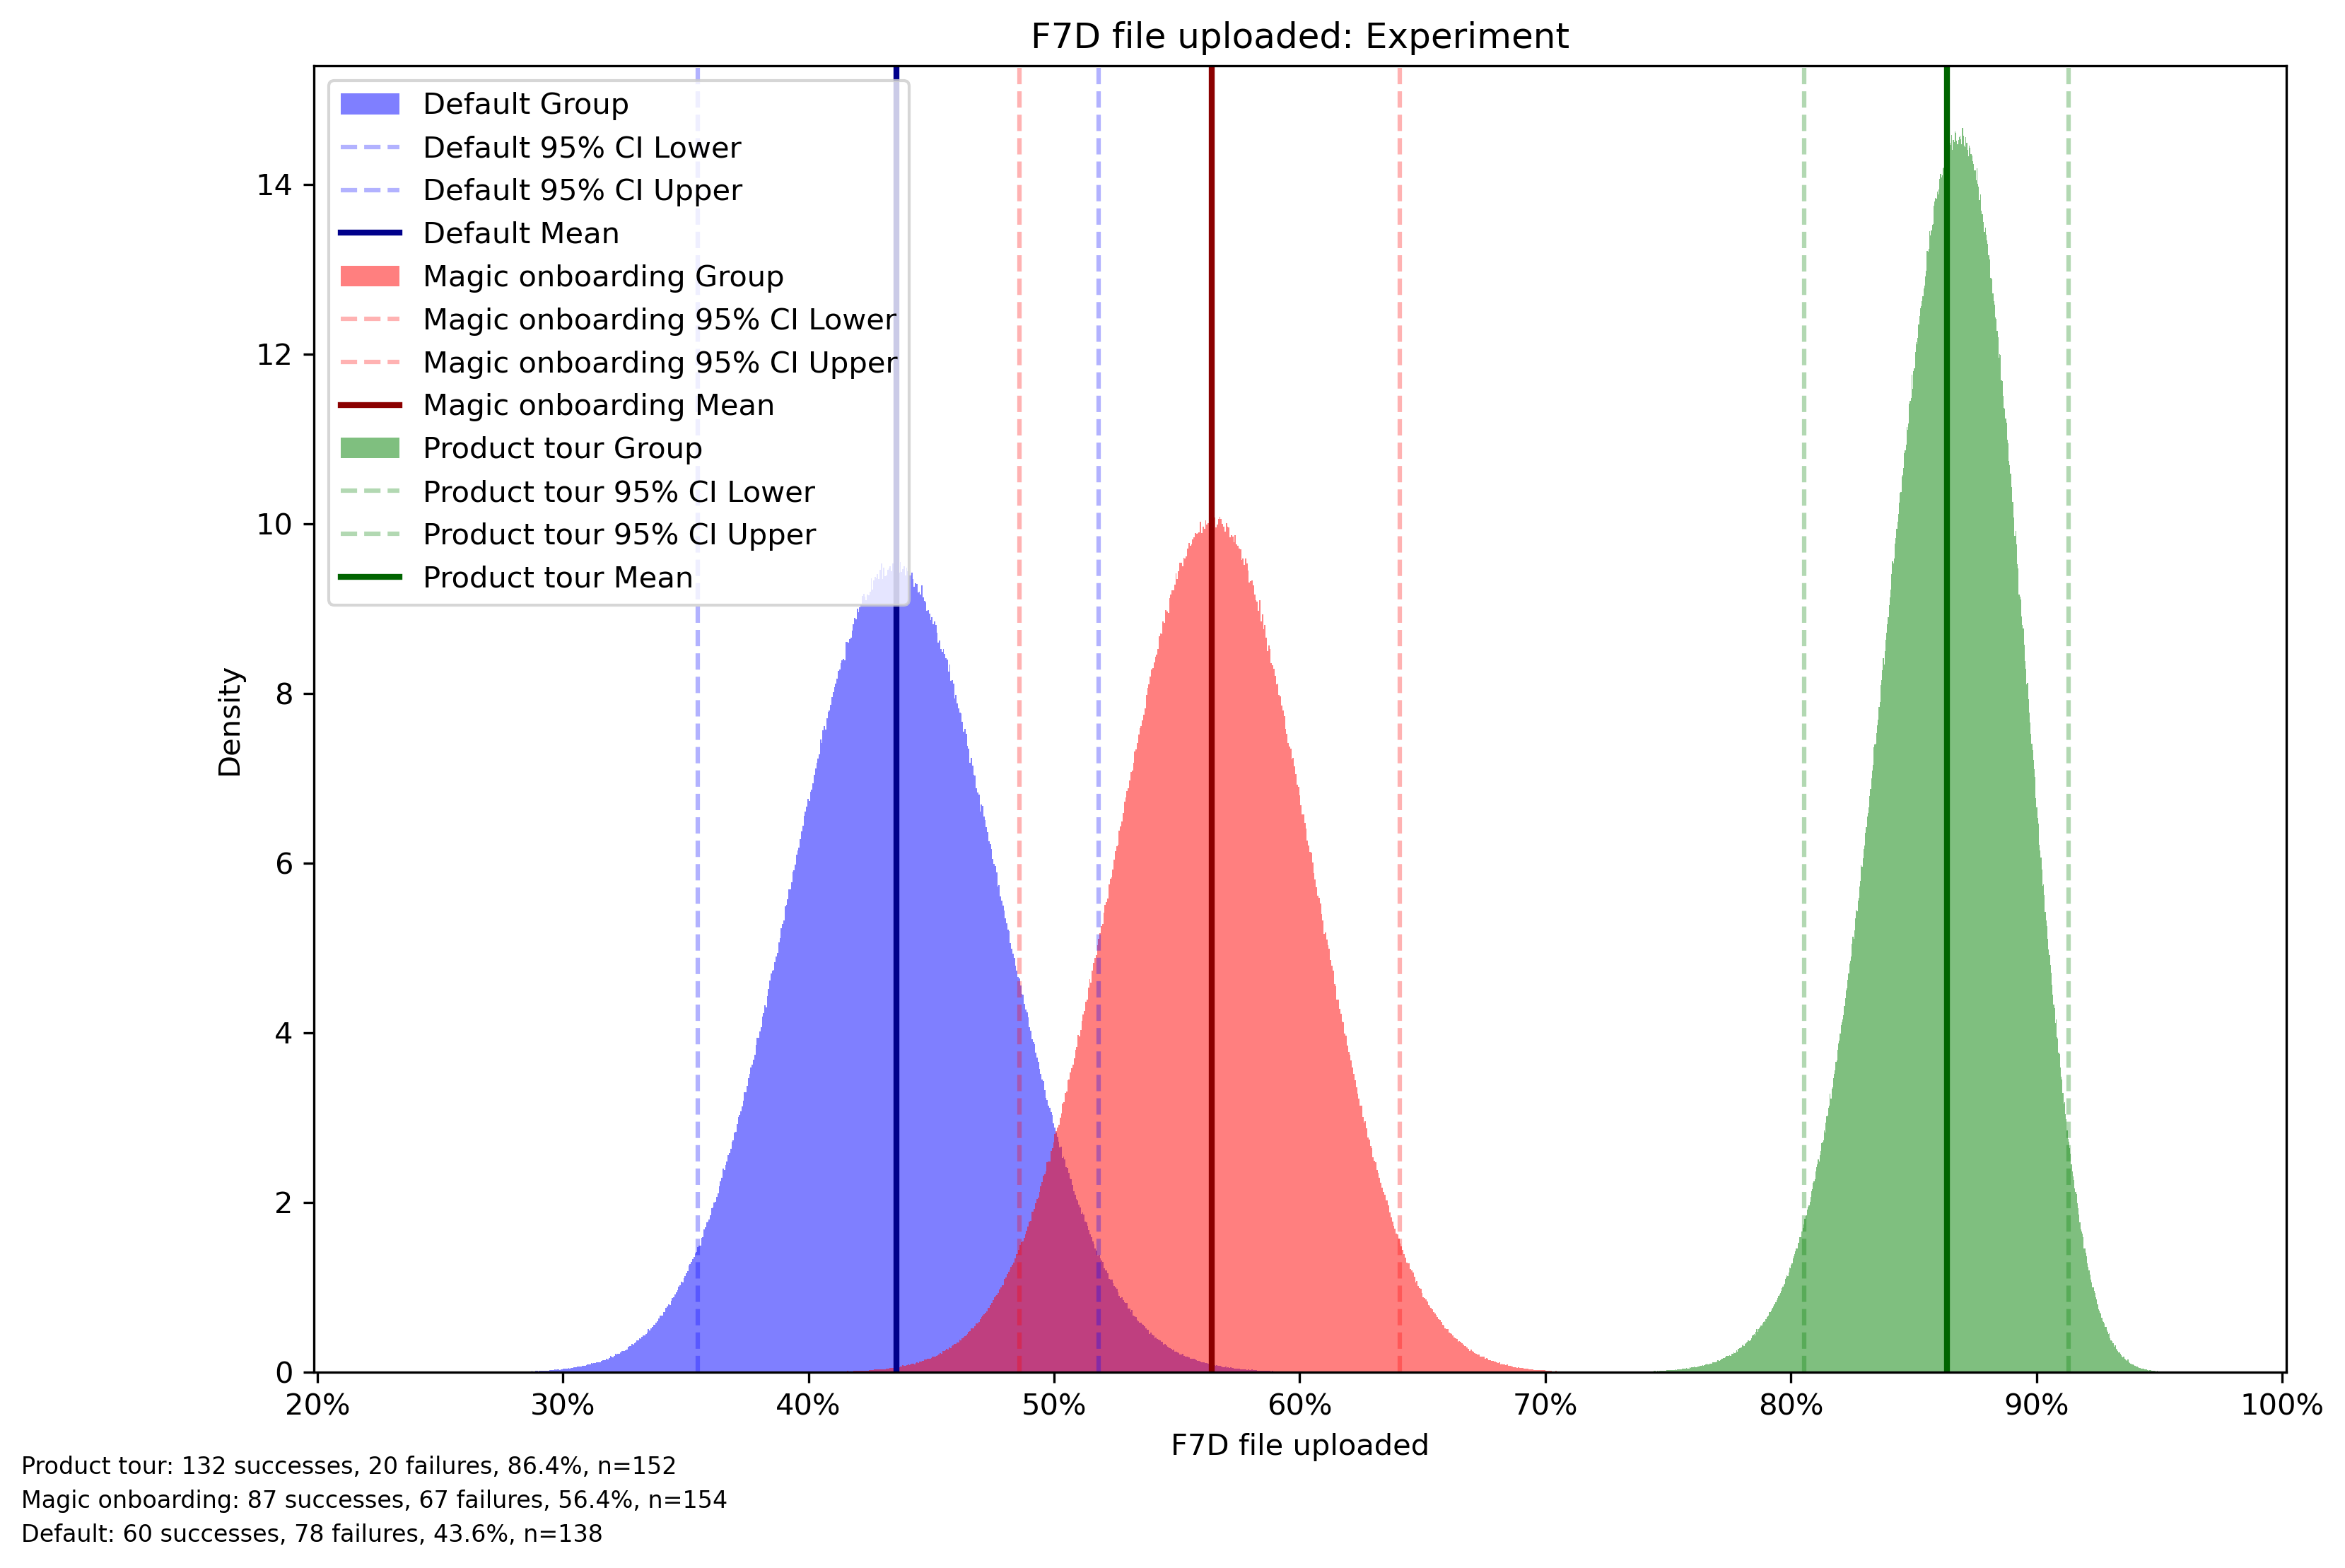

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Calculate posterior parameters for Beta distributions
alpha_post_control = alpha_prior + control_successes
beta_post_control = beta_prior + (control_trials - control_successes)

alpha_post_treatment_A = alpha_prior + treatment_A_successes
beta_post_treatment_A = beta_prior + (treatment_A_trials - treatment_A_successes)

alpha_post_treatment_B = alpha_prior + treatment_B_successes
beta_post_treatment_B = beta_prior + (treatment_B_trials - treatment_B_successes)

# Number of samples
num_samples = 10000000

# Sample from the Beta distributions
control_samples = np.random.beta(alpha_post_control, beta_post_control, num_samples)
treatment_A_samples = np.random.beta(alpha_post_treatment_A, beta_post_treatment_A, num_samples)
treatment_B_samples = np.random.beta(alpha_post_treatment_B, beta_post_treatment_B, num_samples)

# Calculate means
control_mean = np.mean(control_samples)
treatment_A_mean = np.mean(treatment_A_samples)
treatment_B_mean = np.mean(treatment_B_samples)

# Calculate 95% credible intervals
control_credible_intervals = np.percentile(control_samples, [2.5, 97.5])
treatment_A_credible_intervals = np.percentile(treatment_A_samples, [2.5, 97.5])
treatment_B_credible_intervals = np.percentile(treatment_B_samples, [2.5, 97.5])

# Function to calculate Bayes Factor
def calculate_bayes_factor(samples1, samples2):
    p_samples1_better = np.mean(samples1 > samples2)
    p_samples2_better = 1 - p_samples1_better
    return p_samples1_better / p_samples2_better

# Create a matrix for Bayes Factors
samples = [control_samples, treatment_A_samples, treatment_B_samples]
bayes_matrix = np.zeros((3, 3))

for i in range(3):
    for j in range(3):
        if i != j:
            bayes_matrix[i, j] = calculate_bayes_factor(samples[i], samples[j])

# Define the dHart categories
def dHart_category(bayes_factor):
    if bayes_factor < 1:
        return "Negative"
    elif 1 <= bayes_factor < 1.6:
        return "Barely worth mentioning"
    elif 1.6 <= bayes_factor < 3.3:
        return "Substantial"
    elif 3.3 <= bayes_factor < 5.0:
        return "Strong"
    elif 5.0 <= bayes_factor < 6.6:
        return "Very strong"
    else:
        return "Decisive"

# Create a matrix for dHart categories
dhart_matrix = np.vectorize(dHart_category)(bayes_matrix)

# Plotting the Bayes Factor heatmap
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(bayes_matrix, annot=dhart_matrix, fmt='', cmap='RdBu_r', xticklabels=variants, yticklabels=variants)
plt.title('Bayes Factor Matrix (Y variant greater than X variant)')
plt.xlabel('Variant (X)')
plt.ylabel('Variant (Y)')
plt.show()

# Output the credible intervals and means as percentages
print("95% Credible Intervals for Rates:")
print(f"{variants[0]} Group: [{control_credible_intervals[0] * 100:.2f}%, {control_credible_intervals[1] * 100:.2f}%]")
print(f"{variants[1]} Group: [{treatment_A_credible_intervals[0] * 100:.2f}%, {treatment_A_credible_intervals[1] * 100:.2f}%]")
print(f"{variants[2]} Group: [{treatment_B_credible_intervals[0] * 100:.2f}%, {treatment_B_credible_intervals[1] * 100:.2f}%]")

print()

print("Mean Conversion Rates:")
print(f"{variants[0]} Group: {control_mean * 100:.2f}%")
print(f"{variants[1]} Group: {treatment_A_mean * 100:.2f}%")
print(f"{variants[2]} Group: {treatment_B_mean * 100:.2f}%")

print()

# Check if credible intervals overlap
control_lower, control_upper = control_credible_intervals
treatment_A_lower, treatment_A_upper = treatment_A_credible_intervals
treatment_B_lower, treatment_B_upper = treatment_B_credible_intervals

def check_overlap(lower1, upper1, lower2, upper2):
    return upper1 < lower2 or upper2 < lower1

if check_overlap(control_lower, control_upper, treatment_A_lower, treatment_A_upper) and \
   check_overlap(control_lower, control_upper, treatment_B_lower, treatment_B_upper):
    print("The credible intervals do not overlap, indicating a significant difference between the groups.")
else:
    print("The credible intervals overlap, indicating no significant difference between the groups.")

# Calculate percentage uplift
uplift_A = (treatment_A_mean / control_mean - 1) * 100
uplift_B = (treatment_B_mean / control_mean - 1) * 100
print(f"Percentage Uplift for {variants[1]}: {uplift_A:.2f}%")
print(f"Percentage Uplift for {variants[2]}: {uplift_B:.2f}%")

# Plot the distributions
plt.figure(figsize=(12, 8), dpi=300)

# Plot control group distribution
plt.hist(control_samples, bins=800, alpha=0.5, label=variants[0] + ' Group', color='blue', density=True)
plt.axvline(x=control_credible_intervals[0], color='blue', linestyle='--', alpha=0.3, label=variants[0] + ' 95% CI Lower')
plt.axvline(x=control_credible_intervals[1], color='blue', linestyle='--', alpha=0.3, label=variants[0] + ' 95% CI Upper')
plt.axvline(x=control_mean, color='darkblue', linestyle='-', linewidth=2, label=variants[0] + ' Mean')

# Plot treatment A group distribution
plt.hist(treatment_A_samples, bins=800, alpha=0.5, label=variants[1] + ' Group', color='red', density=True)
plt.axvline(x=treatment_A_credible_intervals[0], color='red', linestyle='--', alpha=0.3, label=variants[1] + ' 95% CI Lower')
plt.axvline(x=treatment_A_credible_intervals[1], color='red', linestyle='--', alpha=0.3, label=variants[1] + ' 95% CI Upper')
plt.axvline(x=treatment_A_mean, color='darkred', linestyle='-', linewidth=2, label=variants[1] + ' Mean')

# Plot treatment B group distribution
plt.hist(treatment_B_samples, bins=800, alpha=0.5, label=variants[2] + ' Group', color='green', density=True)
plt.axvline(x=treatment_B_credible_intervals[0], color='green', linestyle='--', alpha=0.3, label=variants[2] + ' 95% CI Lower')
plt.axvline(x=treatment_B_credible_intervals[1], color='green', linestyle='--', alpha=0.3, label=variants[2] + ' 95% CI Upper')
plt.axvline(x=treatment_B_mean, color='darkgreen', linestyle='-', linewidth=2, label=variants[2] + ' Mean')

# Add labels and title
plt.xlabel(f'{target_variable}')
plt.ylabel('Density')
plt.title(f'{target_variable}: Experiment')
plt.legend()

# Add text annotations for successes, failures, mean conversion rate, and total n
control_failures = control_trials - control_successes
treatment_A_failures = treatment_A_trials - treatment_A_successes
treatment_B_failures = treatment_B_trials - treatment_B_successes
control_text = f'{variants[0]}: {control_successes} successes, {control_failures} failures, {control_mean * 100:.1f}%, n={control_trials}'
treatment_A_text = f'{variants[1]}: {treatment_A_successes} successes, {treatment_A_failures} failures, {treatment_A_mean * 100:.1f}%, n={treatment_A_trials}'
treatment_B_text = f'{variants[2]}: {treatment_B_successes} successes, {treatment_B_failures} failures, {treatment_B_mean * 100:.1f}%, n={treatment_B_trials}'

plt.figtext(0.01, 0.01, control_text, ha='left', fontsize=8)
plt.figtext(0.01, 0.03, treatment_A_text, ha='left', fontsize=8)
plt.figtext(0.01, 0.05, treatment_B_text, ha='left', fontsize=8)

# Set x-axis to percentage format
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# Show the plot
plt.show()